In [1]:
from slugify import slugify
import numpy as np
import pandas as pd
import scipy.stats


import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
# from matplotlib.patches import Patch
# from matplotlib.lines import Line2D
import seaborn as sns

import arviz as az
import pymc as pm
import xarray as xr

import json
import pgamma

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
ref_prior = (1, 100)

# location data: characteristices of the sensors
# make sure that the sensor (location names) are slugged
# that is the strings are either lower case or hyphens
bi = pd.read_csv("dc_locations.csv")
# the guesses from the students
guessed = pd.read_csv('guesses.csv')

# the model results in json format

with open('petite_lac.json', 'r') as outfile:
    petiteLac = json.load(outfile)
with open('grand_lac.json', 'r') as outfile:
    grandLac = json.load(outfile)
with open('haut_lac.json', 'r') as outfile:
    hautLac = json.load(outfile)    
with open('grand_lac_municipal.json', 'r') as outfile:
    grandLacMunicipal = json.load(outfile)
with open('grand_lac_summary.json', 'r') as outfile:
    grandLacSummary = json.load(outfile)    
with open('haut_lac_municipal.json', 'r') as outfile:
    hautLacMunicipal = json.load(outfile)
with open('haut_lac_summary.json', 'r') as outfile:
    hautLacSummary = json.load(outfile)    
with open('petite_lac_municipal.json', 'r') as outfile:
    petiteLacMunicipal = json.load(outfile)
with open('petite_lac_summary.json', 'r') as outfile:
    petiteLacSummary = json.load(outfile)

# The aggregated data and survey results for any feature (lake, river, river-basin or city)
# can be accessed through the pgamma module. 
report_name="Lac Léman"
feature="feature"
feature_name="lac-leman"

# retrieve the current data and the most common codes for the region of interest
# there is no need to provide a data source. It is included in the module. 
# from the module we request the complete report for Lac Léman from IQAASL porject
# as well as a list of the most common codes for the lake
report_leman, codes = pgamma.get_most_common_and_aggregated_feature_report(
    report_name=report_name, pg=feature, pgn=feature_name)
codes.remove("G117")
# get the report of all the codes from the lake data
#  this is is an N*D array. he column names are the first row of the array
# so drop the first row and rename the columns and limit the results
# to the codes in "codes"
dr = report_leman.make_report_code_summary()
di = pd.DataFrame(data=dr[1:], columns=dr[0])
# the summary data of the most common codes from Lac Léman
# between March 2020 and May 2021
mcommon = di[di.Code.isin(codes)]

# lac leman has three distinct regions, Haut lac, Grand lac and Petite lac
grand_lac = ['Tolochenaz',
     'Bourg-en-Lavaux', 
     'Morges', 
     'Allaman', 
     'Lausanne', 
     'Saint-Sulpice (VD)', 
     'Préverenges', 
     'Rolle',
    ]
haut_lac = ['La Tour-de-Peilz', 'Vevey', 'Montreux',  'Saint-Gingolph']
petite_lac = ['Gland', 'Versoix', 'Genève']

# All survey records (including IQAASL)
eix = pd.read_csv("ei_uptotdate.csv")
eix["date"] = pd.to_datetime(eix["date"])

# the data prior to the sample date
ei = eix[eix["date"] < "2022-10-01"]
# mask for the most common codes
code_mask = (ei.code.isin(codes))
# the data prior to the sample data
# only the codes of interest
d = ei[code_mask].copy()

log started


### LITTER MONITORING WITH SOLID WASTE ENGINEERS

#### implementing a probabilistic model to predict shoreline litter values

*purpose: test the implementation of the model results*

Students from the École Polytechnique Fédérale in Lausanne conduct a litter survey on the shoreline of Saint Sulpice, a city on Lake Geneva Switzerland. This year the new students were asked to estimate how many of each of the most common objects they would find at the beach, that afternoon. Once the students were divided into two groups, they were handed a sheet of paper that had the list of the most common objects found on Lake Geneva. They were instructed to write down what they thought would be the total number of each object they would find.

In this section we address the known facts about litter density on the shoreline and propose a model based on the negative binomial distribution. The results of the model are compared to what was found that day and to the students estimations.

A more complete introduction to the subject is on available here: [hammerdirt](https://hammerdirt.ch/)

#### CONTENTS

1. Prior data
2. Summary of prior information
3. Model definition
4. Use cases
5. Example: Density of cotton swabs
   1. Comparing cumulative distribtuions
   2. Comparing the mean, median and quantiles
   3. Comparing observed to predicted distributions
5. Comparing model results to student estimations


## Prior information

### Prior data

The prior data is all survey records on Lake Geneva from 2015 to October 1, 2022.

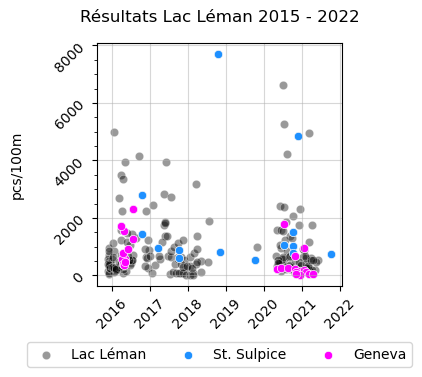

In [3]:
# the survey totals for the lake and Saint Sulpice
# the sum in pcs/100m of each sample since 2015
sp_prior = ei[(ei.city ==  'Saint-Sulpice (VD)')].copy()
g_prior = ei[(ei.city ==  'Genève')].copy()
cdt = sp_prior.groupby(["loc_date", "date", "sensor"], as_index=False).agg({"quantity":"sum", "pcs_m":"sum"})
gdt = g_prior.groupby(["loc_date", "date", "sensor"], as_index=False).agg({"quantity":"sum", "pcs_m":"sum"})
daily_totals = ei.groupby(["loc_date", "date", "sensor"], as_index=False).agg({"quantity":"sum", "pcs_m":"sum"})
fig, ax = plt.subplots(figsize=(4, 4))

daily_totals["date"] = pd.to_datetime(daily_totals["date"])
cdt["date"] =  pd.to_datetime(cdt["date"])
gdt["date"] =  pd.to_datetime(gdt["date"])

sns.scatterplot(data=daily_totals, x="date", y="pcs_m", color="black", alpha=0.4, label="Lac Léman", ax=ax)
sns.scatterplot(data=cdt, x="date", y="pcs_m", color="dodgerblue", label="St. Sulpice", ax=ax)
sns.scatterplot(data=gdt, x="date", y="pcs_m", color="magenta", label="Geneva", ax=ax)
ax.set_ylabel("pcs/100m", labelpad=20)
ax.set_xlabel(" ")
ax.set_title("Résultats Lac Léman 2015 - 2022", fontsize=12, pad=15)
ax.tick_params(axis="both", which="both", labelsize=10, rotation=45)
ax.legend(bbox_to_anchor=(0.5,-.2), loc="upper center", ncol=3)
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(which='major', axis='both', alpha=0.5)
plt.tight_layout()
plt.savefig("survey_totals.png", dpi=300)
plt.show()

### The most common objects under consideration

In [4]:
mcommon

,Code,Description,N pieces,pcs/m,% of total,Fail rate
0,G30,"Food wrappers; candy, snacks",1679,0.22,0.0,0.959
2,G33,"Cups, lids, single use foamed and hard plastic",196,0.02,0.0,0.571
3,G10,Food containers single use foamed or plastic,288,0.01,0.0,0.510
4,G70,Shotgun cartridges,345,0.01,0.0,0.520
5,G178,"Metal bottle caps, lids & pull tabs from cans",308,0.03,0.0,0.714
6,G23,Lids unidentified,262,0.02,0.0,0.582
8,G27,Cigarette filters,3116,0.47,0.0,0.949
9,G32,Toys and party favors,192,0.02,0.0,0.633
11,G67,Industrial sheeting,1058,0.09,0.0,0.776
15,G25,"Tobacco; plastic packaging, containers",295,0.02,0.0,0.551


### Summary of prior knowledge

We assume that the beach litter survey results are **vectors** that describe the interaction/exchange of trash (all sizes > 0mm) between the survey location and the body of water it borders. *Body of water* refers to areas of reduced current flow in a river basin. For example lake Geneva to the Rhône or Bielersee to the Aare. Therefore, the magnitude of the interaction/exchange is quantified by the rate component of the vector that describes the interaction.  

1. The survey results represent the minimum possible value for an object. It is certain that not all objects that were present at a location were indetified and counted. Furtthermore, objects that are found can be misidentified or the wrong code applied to the record upon data entry.

2. There is a relationship to the number of objects suspended in the body of water and the number of objects that are counted and identitfied in the strand-line at a survey. The number of objects in suspension is unknown.

3. Objects in suspension are trasnported according to the direction of the river basin, surface currents, wind currents and meteorological events. The magnitude of the exchange of objects between the shoreline and the body of water is also influenced by local topography. The magnitued of this exchange is unknown for the lake in general nor for any location in particular.

4. Each location or beach produces/emitts particles that are exchanged with the lake. Those particles get transported according to 3. 

5. Storm water drains, streams, rivers and canals ( hydrologic inputs ) are sources of particles in suspension. The number and size of hydrologic inputs is a factor in the number of particles in suspension for a  body of water.

6. The three different regions of Lac Léman are characterized by different currents, average depth and resident time. 

The magnitude of the *trash* vector on the beach is the result of many interactions. One possible method to forecasting results could include quantifying each interaction term. This would be helpfull information but is not strictly required. From a resource perspective this would require that three additional sources of information (for each quantified interaction) be maintained and accessible for each location so that forecasting could be accomplished. None of which currently exist at a required precision level for any specific location. **The question is about the magnitude of the *trash* vector (the value of pieces/meter) and not any other attribute, for this there is direct evidence.** The shortcomings or bias of this evidence is summarized in 1, pieces/meter describes the results of the exchanges in 2-6.

The Negative Binomial distribution has been suggested by WRU and the JRC when calculating trend lines or identifying extreme values from a dataset ( JRC ). The Generalized Linear Model (GLM) method proposed by WRU uses the survey totals and group totals to determine trend lines, with the recomendation to use objects that are indentified frequently. The example in the report is Single Use Plastics (SUPS). This method does not exclude any survey results and is constrained geographically. 

#### Models and priors

**Prior data:** The method proposed by WRU is attractive because of the properties of the NB and its use in evaluating count data in many other fields. To the model proposed by WRU we add a definition of objects that are *identified frequently* as any object that was found in at least 50% of the surveys or any object with a cumulative total that places them in the top ten most abundant. This method considers both the frequency and proportion of an object in relation to the total and provides a standard definition for "identified frequently".

**Model:** Given conditions 2-5 we assume that the survey results for the most common objects are NB distributed with parameters $\alpha$ and $\lambda$. $A$ is Exponentialy distributed with parameter $i$ and $\Lambda$ is the result of the interaction of the region, municpality and the location on the survey value $Y$ for a an object. The intercept  and all interaction terms are truncated to $x \geq 0$.

$$
\begin{aligned} 
Y  &\sim NB(\lambda, \alpha) \\
\alpha &\sim Exponential(i) \\
\lambda &= B_{intercept} + B_{city}X * B_{sensor}X * B_{object}X \\
B_{intercept} &\sim  HalfNormal(\mu, \sigma), \mu \geq 0 \\
B_{city} &\sim TruncatedNormal(\mu, \sigma) \\
B_{sensor} &\sim TruncatedNormal(\mu, \sigma) \\
B_{object} &\sim TruncatedNormal(\mu, \sigma) \\
\end{aligned}
$$

### Use Cases

The intended purpose of the model is to allow end users to consult current and predicted values for any number of planning purposes. This includes planning holiday weekends or designing a process that is supposed to reduce trash in the water for a region or body of water. Our conditions of success are focussed on practicallity and implementation. The testing of the model and the results from those tests should be easy to consult and understand. The definitive test should always be a direct comparison between what was found and the forecast. The initial test period should be as long as the baseline collection period. In this case one year.

#### Finding locations with the least exposure

The goal is to identify locations where the probability of an encountering an object or a group of objects is lowest. Regional, municpal and individual survey results are considered. If $P$ is the probability of finding an object then this would be the location where $1-P$ is greatest. 

#### Finding a source or area of accumulation

The goal is to identify potential sources for an object or a group of objects. This also helps identify objects where location does not play a dominant role in the value of $P$. For some objects the value of $P$ for a range of values of $X$ should be fairly close regardless of the location. Suggesting that the object is ubquitous in the environment, see chapter 20 of the IQAASL report.

#### Finding success stories

The value of $P$ for a range of $X$ will change as data enters. If $P$ for a given value trends down at a location then this indicates that conditions at the location are likely improving and that the effect is observable. 

**Conditions of success:**

1. On average have a better prediction rate than a random guess
2. The forecast describes a compromise between the city and the subregion
3. Predicted values are reasonable compared to historical results
4. The forecast is sensitive to the addition of new information

### Summary of results by region and subregion

The mean pcs/100m of the most common objects indentified for the period 2020-2021. The variance of the survey results increase with the required geographical precision of the assessment. This relationship is in part due to the decreasing number of samples per region or sub region, ie. there are 250  surveys for the lake and only 15 for Saint Sulpice. The average pcs/100m at Saint Sulpice is double that of the lake, while the average of the grand-lac is very close to the lake.

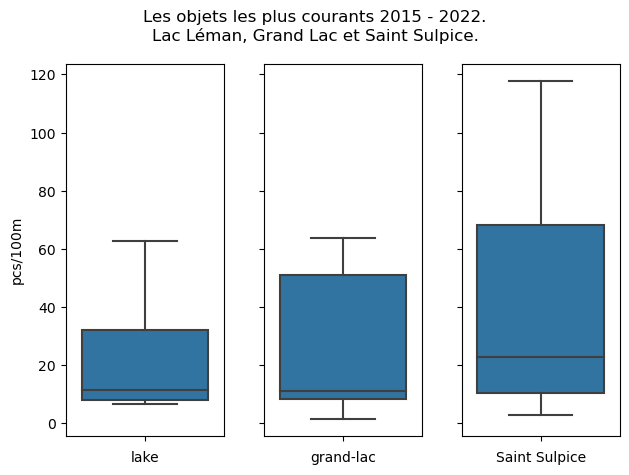

In [5]:
def add_group(x, haut_lac, petite_lac, grand_lac):
    
    if x in haut_lac:
        d = "haut-lac"
    elif x in petite_lac:
        d = "petite-lac"
    elif x in grand_lac:
        d = "grand-lac"
    else:
        return x
    return d
    
# recall that ei is all the data prior to the sample date
# mean_pcode is the average result in pcs_m for each code
mean_pcode = d.groupby("code").pcs_m.mean()

# assign the mean and calculate the difference of each result
# to the mean for the object (the mean sum of squared diffrences)
d["mean_c"] = d["code"].map(lambda x: mean_pcode.loc[x])
d["mean_diff"] = d["pcs_m"] - d["mean_c"]
d["mean_diff_sqrd"] = d["mean_diff"]**2
d["root_mean_diff"] = d["mean_diff_sqrd"]**1/2
d["group"] = "lake"
d["group"] = d["city"].map(lambda x: add_group(x, haut_lac, petite_lac, grand_lac))

# the survey results for the most common codes at the 
# different aggregate levels
done = d.groupby("code", as_index=False)["pcs_m"].mean()
dtwo = d[d.group == "grand-lac"].groupby("code", as_index=False)["pcs_m"].mean()
dthree = d[d.city == 'Saint-Sulpice (VD)'].groupby("code", as_index=False)["pcs_m"].mean()

fig, ax = plt.subplots(1,3, sharey=True)

xlabels = ["lake", "grand-lac", "Saint Sulpice"]
ax1 = ax[0]
ax2 = ax[1]
ax3 = ax[2]

for i, anax in enumerate([ax1, ax2, ax3]):
    anax.set_xlabel(xlabels[i])

sns.boxplot(data=done, y="pcs_m",  showfliers=False, ax=ax1)
sns.boxplot(data=dtwo, y="pcs_m",  showfliers=False, ax=ax2)
sns.boxplot(data=dthree, y="pcs_m",  showfliers=False, ax=ax3)

for anax in [ax2, ax3]:
    anax.set_ylabel(" ")

title_one = "Les objets les plus courants 2015 - 2022."
title_two = "Lac Léman, Grand Lac et Saint Sulpice."

ax1.set_ylabel("pcs/100m")
plt.suptitle(f"{title_one}\n{title_two}")
plt.tight_layout()
plt.savefig("most_common_objects_regional_av.jpeg", dpi=300)
plt.show()

In [6]:
fsummaries = f"""

Summary lake:
{done.pcs_m.describe()}

Summary grand-lac:
{dtwo.pcs_m.describe()}

Summary Saint Sulpice:
{dthree.pcs_m.describe()}

        """
print(fsummaries)



Summary lake:
count     23.000000
mean      32.517478
std       43.112852
min        6.548000
25%        7.955269
50%       11.421687
75%       31.961847
max      138.600000
Name: pcs_m, dtype: float64

Summary grand-lac:
count     23.000000
mean      38.502694
std       54.140661
min        1.576271
25%        8.330508
50%       11.258621
75%       51.169492
max      219.600000
Name: pcs_m, dtype: float64

Summary Saint Sulpice:
count     23.000000
mean      66.606418
std       97.635158
min        2.857143
25%       10.607143
50%       22.857143
75%       68.192308
max      345.733333
Name: pcs_m, dtype: float64

        


### Implementing the model in PyMC

#### Example of one object type: Cotton swabs

According to the summary of prior information there is an interaction of forces acting on the beach. Debris from the region, exchange of debris with other locations in proximity and debris that is produced and deposited on site. These forces are approximated in the model by a Normal distribution that is truncated at 0 and is indexed to the results at the regional, municipal and beach level. The intercept is also greater than or equal to zero and is modeled with a HalfNormal distribution.

```python

with pm.Model(coords=coords) as glmNBR:
    
    comp_idx = pm.Data("codes", components, dims="obs_id", mutable=True)
    sensor_idx = pm.Data("sensor", sensors, dims="obs_id", mutable=True)
    city_idx = pm.Data("city", cities, dims="obs_id", mutable=True)
    observed = pm.ConstantData("obs", wd.pcs_m.values, dims="obs_id")    
   
    comp = pm.TruncatedNormal("c", mu=0, sigma=100, lower=0, dims="component")
    city = pm.TruncatedNormal("cit", mu=0, sigma=100, lower=0, dims="city")
    sensor = pm.TruncatedNormal("s", mu=0, sigma=100, lower=0, dims="sensors")
    an_int = pm.HalfNormal("an_int", sigma=5, dims="obs_id")
    
        
    lmbda = pm.Deterministic("mu", an_int +  comp[comp_idx]*sensor[sensor_idx]*city[city_idx])
    alpha = pm.Exponential("alpha", lam=0.5, dims="obs_id")    
    
    found = pm.NegativeBinomial("found", mu=lmda, alpha=alpha, observed=observed)
```

The joint distribution of the forces plus the value of the intercept is the mu paramteter of the NB distribution. The initial parameter values are all the same because we are using all available data. 

In [7]:
# the plastic bottle caps are combined into one code:
som_caps = ["G21", "G24", "G23"]
columns = ["pcs_m","quantity", "group", "city", "code", "sensor"]

dcaps = d[d.code.isin(som_caps)].copy()
dnocaps = d[~d.code.isin(som_caps)].copy()
dcaps["code"] = "Gcaps"
dtest = pd.concat([dnocaps, dcaps])

# workdata
workData = dtest[columns].copy()
workData.reset_index(inplace=True, drop=True)

# most common codes
codes = workData.code.unique()

# model variables
code = "G95"
region = "grand-lac"

# maskdata to region and code and reset index
maskOne = workData.group == region
wd = workData[(maskOne)&(workData.code == code)].copy()
wd.reset_index(inplace=True, drop=True)

# factorize the categorical columns
group, glabels = pd.factorize(wd.group)
components, comp_labels = pd.factorize(wd.code)
sensors, sensor_labels = pd.factorize(wd.sensor)
cities, city_labels = pd.factorize(wd.city)

# define labels and coordinates for inference data
coords = {"component":comp_labels, "city":city_labels, "group": glabels, "sensors":sensor_labels, "obs_id":wd.index.values}

# model
with pm.Model(coords=coords) as glmNBR:
    
    comp_idx = pm.Data("codes", components, dims="obs_id", mutable=True)
    sensor_idx = pm.Data("sensor", sensors, dims="obs_id", mutable=True)
    city_idx = pm.Data("city", cities, dims="obs_id", mutable=True)
    observed = pm.ConstantData("obs", wd.pcs_m.values, dims="obs_id")    
   
    comp = pm.TruncatedNormal("c", mu=0, sigma=100, lower=0, dims="component")
    city = pm.TruncatedNormal("cit", mu=0, sigma=100, lower=0, dims="city")
    sensor = pm.TruncatedNormal("s", mu=0, sigma=100, lower=0, dims="sensors")
    an_int = pm.HalfNormal("an_int", sigma=5, dims="obs_id")
    
        
    mu = pm.Deterministic("mu", an_int +  comp[comp_idx]*sensor[sensor_idx]*city[city_idx])
    alpha = pm.Exponential("alpha", lam=0.5, dims="obs_id")    
    
    found = pm.NegativeBinomial("found", mu=mu, alpha=alpha, observed=observed)
    
modelgraph = pm.model_graph.model_to_graphviz(glmNBR)

In [8]:
with glmNBR:
    sampled = pm.sample(1000, tune=2000)
    pm.sample_posterior_predictive(sampled ,extend_inferencedata=True, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 116 seconds.


### Are the predicted results reasonable?

Conditions two and three require that the predicted values should be reasonable and represent a compromise between the different vectors. To check this random samples are drawn (n = the number of observed samples) from the posterior distribution for each of the different levels (region, city and location). The mean, median and cumulative distribution functions are compared to the observed values. 

In [9]:
city =  'Saint-Sulpice (VD)'
label_value ='tiger-duck-beach'
label = "sensor"

cdms = wd[wd.city == city]
cdims = cdms.index.values

sdms =wd[wd[label] == label_value]
sensor_dims = sdms.index

# draw samples from the posterior predictive distribution
# the number of samples drawn is equal to the number of observed samples
post_all = az.extract(sampled.posterior_predictive, num_samples=len(wd))
post_city = az.extract(sampled.posterior_predictive.sel({'found_dim_0': cdims}), num_samples=len(wd))
post = az.extract(sampled.posterior_predictive.sel({'found_dim_0': sensor_dims}), num_samples=len(wd))

# the observed averages and median:
obs_means = []
obs_quantiles = []
for element in [wd, cdms, sdms]:
    obs_mean = element.pcs_m.mean()
    obs_median = element.pcs_m.median()
    qtiles = np.quantile(element.pcs_m.values, [.1, .25, .5, .75, .9])
    obs_quantiles.append(qtiles)
    obs_means.append((obs_mean, obs_median))
pred_means = []
pred_quantiles = []
for element in [post_all, post_city, post]:
    pred_mean = element.mean().found.values
    pred_median = element.median().found.values
    qtiles = np.quantile(np.ravel(element.found.values), [.1, .25, .5, .75, .9])
    pred_quantiles.append(qtiles)
    pred_means.append((pred_mean, pred_median))

astrin = "The OBSERVED mean and median for the region, city and sensor\n"
print(astrin)
print(obs_means)

astring = "\nThe PREDICTED mean and median for the region, city and sensor\n"
print(astring)
print(pred_means)

The OBSERVED mean and median for the region, city and sensor

[(63.6271186440678, 34.0), (87.0, 53.0), (132.25, 68.5)]

The PREDICTED mean and median for the region, city and sensor

[(array(56.8543522), array(33.)), (array(76.18765133), array(45.)), (array(85.14830508), array(59.5))]


In this example, the model predictions are on average lower than the observed values. The mean predicted for the sensor is significantly reduced but the median is only reduced by 2 pcs/100m. Even though the average predicted results may be lower, the predicted median values should be similar to the observed.

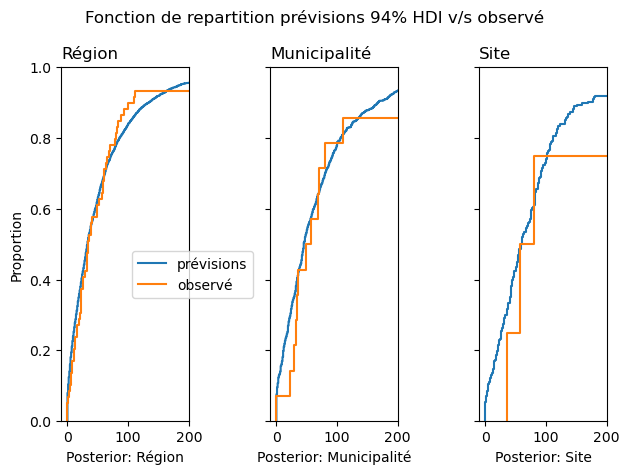

In [10]:
# plot the ECDF of the predicted and observed samples:
fig, axs = plt.subplots(1,3, sharey=True)
xlims = az.hdi(np.ravel(post_all.found))

ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]

for anax in axs:
    anax.set_xlim(xlims[0]-10, xlims[1]+30)

sns.ecdfplot(np.ravel(post_all.found.values), label="prévisions", ax=ax1)
sns.ecdfplot(wd.pcs_m.values, label="observé", ax=ax1)
ax1.legend(bbox_to_anchor=(.5, .5), loc="upper left")

ax1.set_title("Région", loc="left")
ax2.set_title("Municipalité", loc="left")
ax3.set_title("Site", loc="left")
ax1.set_xlabel("Posterior: Région")
ax2.set_xlabel("Posterior: Municipalité")
ax3.set_xlabel("Posterior: Site")

sns.ecdfplot(np.ravel(post_city.found.values), ax=ax2)
sns.ecdfplot(cdms.pcs_m.values, ax=ax2)

sns.ecdfplot(np.ravel(post.found.values),  ax=ax3)
sns.ecdfplot(sdms.pcs_m.values, ax=ax3)

plt.suptitle("Fonction de repartition prévisions 94% HDI v/s observé")

plt.tight_layout()
plt.tight_layout()
plt.savefig("cumulative_dist.jpeg", dpi=300)
plt.show()

In [11]:
astrin = "The OBSERVED quantiles (10%, 20%, 50%, 80%, 90%) for the region, city and sensor\n"
print(astrin)
print(obs_quantiles)

astring = "\nThe PREDICTED quantiles (10%, 20%, 50%, 80%, 90%) for the region, city and sensor\n"
print(astring)
print(pred_quantiles)  

The OBSERVED quantiles (10%, 20%, 50%, 80%, 90%) for the region, city and sensor

[array([  5.6,  16. ,  34. ,  66.5, 102. ]), array([ 24.1 ,  33.25,  53.  ,  77.5 , 224.8 ]), array([ 42.3 ,  51.75,  68.5 , 149.  , 273.2 ])]

The PREDICTED quantiles (10%, 20%, 50%, 80%, 90%) for the region, city and sensor

[array([  1.,  10.,  33.,  72., 133.]), array([  2.,  18.,  45.,  92., 167.]), array([  4.5,  26. ,  59.5, 101. , 164.5])]


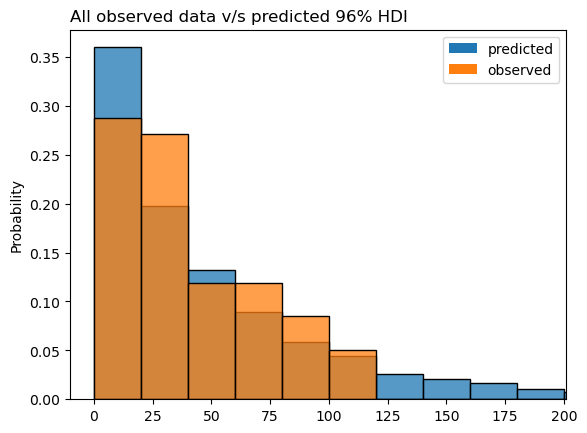

In [12]:
fig, ax1 = plt.subplots()

ax1.set_xlim(xlims[0]-10, xlims[1]+30)
sns.histplot(np.ravel(post_all.found.values), label="predicted", stat="probability", binwidth=20, ax=ax1)
sns.histplot(wd.pcs_m.values, label="observed",stat="probability", binwidth=20, ax=ax1)
ax1.set_title("All observed data v/s predicted 96% HDI", loc="left")

h, l = ax1.get_legend_handles_labels()
h, l = [h[0], h[2]], [l[0], l[2]]
plt.legend(h,l)
plt.show()

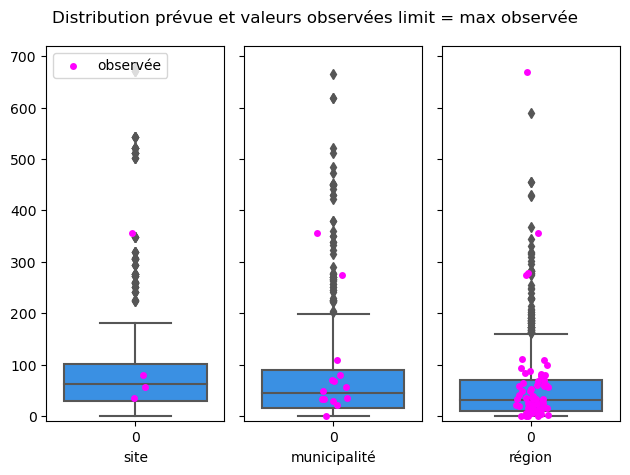

In [20]:

postwd_samps = rng.choice(np.ravel(post_all.found.values), 1000)

post_pp_samps = rng.choice(np.ravel(post.found.values), 1000)

post_city_samps = rng.choice(np.ravel(post_city.found.values), 1000)

city_obs_samps = cdms.pcs_m.values
wd_obs_samps = wd.pcs_m.values
sensor_obs_samps = sdms.pcs_m.values

boxes = [post_pp_samps,post_city_samps,  postwd_samps]
labels = ["site", "municipalité", "région"]

fig, axs = plt.subplots(1, 3, sharey=True)

for i,anax in enumerate(axs):
    sns.boxplot(boxes[i], ax=anax, color="dodgerblue", showfliers=True)
    anax.set_xlabel(labels[i])
    anax.set_ylim(-10, np.max(wd_obs_samps)+50)
    

sns.stripplot(sensor_obs_samps, color="magenta", label="observée", ax=axs[0])
sns.stripplot(city_obs_samps, color="magenta", ax=axs[1])
sns.stripplot(wd_obs_samps, color="magenta",  ax=axs[2])
axs[0].legend(loc="upper left")
plt.suptitle("Distribution prévue et valeurs observées limit = max observée")
plt.tight_layout()
plt.savefig("observed_posterior_boxplots.jpeg", dpi=300)
plt.show()

### The predicted results are reasonable

Consider the inner quantile range (IQR) of predicted v/s observed. In general the IQR of predicted is greater than observed and the median values remain within 10 pcs/100m.

### Are the model predictions better than a guess?

The model defined earlier was run for all objects and all locations on the lake. The predictions and the guessess are compared to what was found by the students. This is calculated by substracting the found value from the guessed and predicted values. The result is squared and then the square root is taken. If the sum of guessed is lower than the sum of modeled then the model did not do any better than a guess. 

We would like the model middle 60% of the model to capture the survey results. Another way to say it is we would like the found values to fall within the 20th and 80th percentile of the posterior predictive distribution.

In [14]:
sensors = ['parc-des-pierrettes', 'plage-de-st-sulpice']
glacDf = pd.DataFrame(grandLac)
ppc = glacDf[glacDf.sensor.isin(sensors)]
ppcPp = ppc[ppc.sensor == sensors[0]].copy()
ppcSp = ppc[ppc.sensor == sensors[1]].copy()

guessedcaps = guessed[guessed.code.isin(["G21", "G24", "G23"])].copy()
guessednocaps = guessed[~guessed.code.isin(["G21", "G24", "G23"])].copy()

these_cols = dcaps.columns
guessedcaps["code"] = "Gcaps"

guessedGcaps = pd.concat([guessedcaps, guessednocaps])

tryi = guessedGcaps.groupby(["beach", "code"]).guess.mean()

ppcPp["guessed"] =ppcPp.code.map(lambda x: tryi.loc["parc-des-pierrettes"][x])
ppcSp["guessed"] =ppcSp.code.map(lambda x: tryi.loc["plage-de-st-sulpice"][x])

eifound = eix[(eix["date"] == "2022-10-06")].copy()
eifound.loc[(eifound.sensor == "plage-de-st-sulpice")&(eifound.code =="Gfrags"), "pcs_m"] = 129/40

einopss = eifound[eifound.sensor != "plage-de-st-sulpice"].copy()
eipss = eifound[eifound.sensor == "plage-de-st-sulpice"].copy()
eipss["pcs_m"] = (eipss.pcs_m * 100).round(3)

eifound = pd.concat([eipss, einopss])
eifoundcaps = eifound[eifound.code.isin(["G21", "G24", "G23"])].copy()
eifoundnocaps = eifound[~eifound.code.isin(["G21", "G24", "G23"])].copy()

these_cols = eifoundcaps.columns
eifoundcaps["code"] = "Gcaps"

eifoundGcaps = pd.concat([eifoundcaps, eifoundnocaps])
eifoundGcaps = eifoundGcaps[eifoundGcaps.code.isin(codes)]

eitry = eifoundGcaps.groupby(["sensor", "code"]).pcs_m.mean()
ppcSp["found"] = ppcSp.code.map(lambda x: eitry.loc["plage-de-st-sulpice"][x])
ppcPp["found"] = ppcPp.code.map(lambda x: eitry.loc["parc-des-pierrettes"][x])

epfl_results = pd.concat([ppcSp, ppcPp])
epfl_results["guessed dif"] = epfl_results.guessed - epfl_results.found
epfl_results["guessed dif²"] = epfl_results["guessed dif"].map(lambda x: np.sqrt(x**2))
epfl_results["model dif"] = epfl_results["median"] - epfl_results.found
epfl_results["model dif²"] = epfl_results["model dif"].map(lambda x: np.sqrt(x**2))

epfl_melted = pd.melt(epfl_results, id_vars=["sensor","code"], value_vars=["model dif", "guessed dif"])

In [15]:
ep_res = epfl_results[["code","sensor", "guessed dif²", "model dif²", "20%", "80%", "found"]]
ppmdif = ep_res.groupby("sensor")["model dif²"].sum()
ppgdif = ep_res.groupby("sensor")["guessed dif²"].sum()

astring = "The sum of PREDICTED - found, aka the sum of squared differences\n"
print(astring)
print(ppmdif)
astring = "\nThe sum of GUESSED - found, aka the sum of squared differences\n"
print(astring)
print(ppgdif)

The sum of PREDICTED - found, aka the sum of squared differences

sensor
parc-des-pierrettes    772.333333
plage-de-st-sulpice    684.500000
Name: model dif², dtype: float64

The sum of GUESSED - found, aka the sum of squared differences

sensor
parc-des-pierrettes    908.148148
plage-de-st-sulpice    980.595238
Name: guessed dif², dtype: float64


In [16]:

ppfound = ppcPp[['code', 'found']].set_index("code")
spfound = ppcSp[['code', 'found']].set_index("code")
sensors = ['parc-des-pierrettes', 'plage-de-st-sulpice']

ranges = pd.DataFrame(grandLac)
ranges = ranges[ranges.sensor.isin(sensors)].copy()
rSp = ranges[ranges.sensor == sensors[1]].copy()
rPp = ranges[ranges.sensor == sensors[0]].copy()
rSp["found"] = rSp.code.map(lambda x: spfound.loc[x]["found"])
rSp["in"] = (rSp.found >= rSp["10%"]) & (rSp.found <= rSp["80%"])
rPp["found"] = rPp.code.map(lambda x: ppfound.loc[x]["found"])
rPp["in"] = (rPp.found >= rPp["10%"]) & (rPp.found <= rPp["80%"])

astring = f"The number of times 'found' was within the specified quantile: {sensors[0]}\n"
print(astring)
print(f"{rPp['in'].sum()} / {len(rPp)}")
astring = f"\nThe number of times 'found' was within the specified quantile: {sensors[1]}\n"
print(astring)
print(f"{rSp['in'].sum()} / {len(rSp)}")

The number of times 'found' was within the specified quantile: parc-des-pierrettes

14 / 21

The number of times 'found' was within the specified quantile: plage-de-st-sulpice

16 / 21


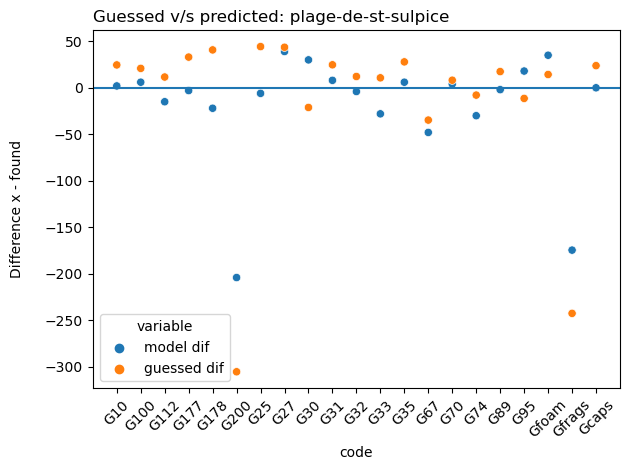

In [17]:
fig, ax = plt.subplots()
data = epfl_melted[epfl_melted.sensor == 'plage-de-st-sulpice']
sns.scatterplot(data=data, x="code", y="value", hue="variable")
ax.axhline(y=0, xmin=0, xmax=1)
ax.tick_params(axis="x", which="both", labelrotation=45)
ax.set_ylabel("Difference x - found", labelpad=15)
ax.set_title("Guessed v/s predicted: plage-de-st-sulpice", loc="left")
plt.tight_layout()
plt.savefig("guessed_predicted_sp.jpeg", dpi=300)
plt.show()

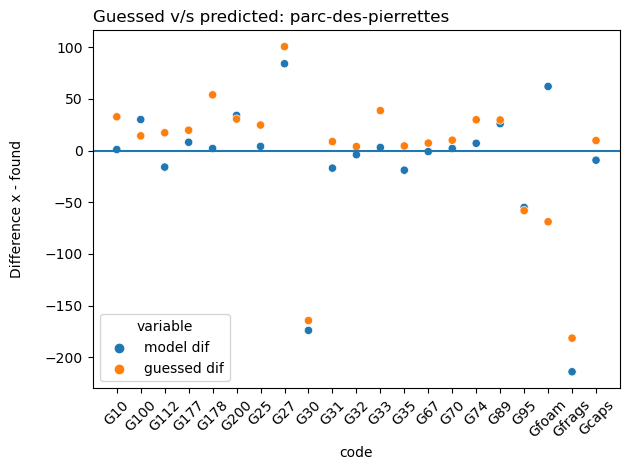

In [18]:
fig, ax = plt.subplots()
data = epfl_melted[epfl_melted.sensor == 'parc-des-pierrettes']
sns.scatterplot(data=data, x="code", y="value", hue="variable")
ax.axhline(y=0, xmin=0, xmax=1)
ax.tick_params(axis="x", which="both", labelrotation=45)
ax.set_ylabel("Difference x - found", labelpad=15)
ax.set_title("Guessed v/s predicted: parc-des-pierrettes", loc="left")
plt.tight_layout()
plt.savefig("guessed_predicted_pp.jpeg", dpi=300)
plt.show()

### The model results are better than a guess

However they could be better. Perhaps the students consulted the results from the previous surveys or maybe they are just good at guessing. For the following reasons we consider think this model is a model that can be improved:

1. The observed results are centered around the median value of the prediction
2. Approximately 70% (30/42) of the found values were within the specified quantile
3. The sum of difference squared is less than the guessed values

### Next steps

1. Develop other models
2. Implement these results in a web-application 
3. Define backend opps to support the model sampling